In [1]:
# load training loss
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
import os

def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def tif_to_np(f_name):
    '''
    convert tif to numpy
    '''
    img = imread(f_name)
    img = img.astype('float32')/255
    return img>0.5


# initialize configuration parameters for a specific experiment
experiment = 'ex11'
initialize(config_path=f"../config/{experiment}")
cfg_vqgan = compose(config_name="vqgan")
cfg_transformer = compose(config_name="transformer")
cfg_dataset = compose(config_name="dataset")

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [2]:
import torch
from lpu3dnet.frame import vqgan

# get the global path
PATH = cfg_dataset.PATH.sub_vol

def get_img_list(idx_list):
    # input: ct image idx
    # output: list of images
    img_list = []
    for ct_idx in [2,3,4,5]:
        for idx in idx_list:
            img = tif_to_np(f'{PATH}/ct_{ct_idx}/{idx}.tif')
            img_list.append(img)
    return img_list

def img_list_to_np(img_list):
    # input: list of images
    # output: numpy array of images
    image = np.stack(img_list,axis=0)
    return image

def idx_to_matrix(img_idx_list):
    # input: ct image idx, list of image idx
    # output: numpy array of images
    img_list = get_img_list(img_idx_list)
    img_matrix = img_list_to_np(img_list)
    img_matrix = img_matrix[:,np.newaxis,...]
    img_tensor = torch.from_numpy(img_matrix).float()

    return img_tensor,img_matrix


def tensor_to_np(tensor):
    # input: tensor
    # output: numpy array
    return tensor.detach().numpy()

root_path = os.path.join(cfg_dataset.checkpoints.PATH, cfg_dataset.experiment)
epoch = 25

model_vqgan = vqgan.VQGAN(cfg_vqgan)
PATH_model = os.path.join(root_path,f'vqgan_epoch_{epoch}.pth')
model_vqgan.load_state_dict(
    torch.load(
            PATH_model,
            map_location=torch.device('cpu')
               )
    )

model_vqgan.eval()

VQGAN(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (channel_up): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNo

In [3]:
import random
img_num = 25
img_idx = [random.randint(0, 7999) for _ in range(img_num)]
img_tensor,img_matrix = idx_to_matrix(img_idx)

from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()

with torch.no_grad():
    decode_img,info,_ = model_vqgan(img_tensor)
    decode_img = img_prc.clean_img(decode_img)
# insert a dimension in the channel

# decode_img = decode_img[:,np.newaxis,...]

In [4]:
compare_stats = {
    'phi':{'phi_real':[],'phi_rec':[]},
    'eul':{'eul_real':[],'eul_rec':[]},
    }

for i in range(len(img_matrix)):
    img = img_matrix[i][0]
    rec_img = decode_img[i][0]
    phi_real,eul_real = img_prc.phi(img), img_prc.eul(img)
    phi_rec,eul_rec = img_prc.phi(rec_img), img_prc.eul(rec_img)
    compare_stats['phi']['phi_real'].append(phi_real)
    compare_stats['phi']['phi_rec'].append(phi_rec)
    compare_stats['eul']['eul_real'].append(eul_real)
    compare_stats['eul']['eul_rec'].append(eul_rec)



# calculate reconstruction error for eul
eul_real = np.array(compare_stats['eul']['eul_real'])
eul_rec = np.array(compare_stats['eul']['eul_rec'])

Text(0.5, 1.0, 'eul comparison')

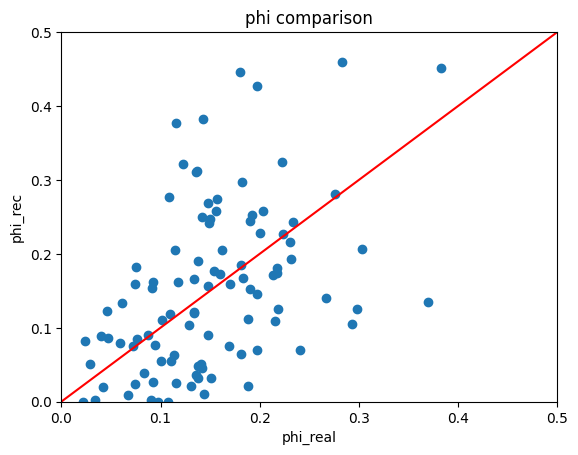

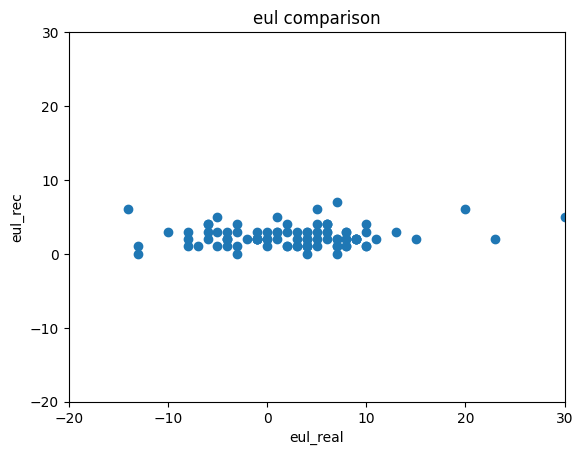

In [5]:
f = plt.figure()
plt.plot(compare_stats['phi']['phi_real'],compare_stats['phi']['phi_rec'],'o')
plt.xlabel('phi_real')
plt.xlim([0,0.5])
plt.ylabel('phi_rec')
plt.ylim([0,0.5])
# plot the line of y=x
plt.plot([0,0.5],[0,0.5],'r')
plt.title('phi comparison')

f = plt.figure()
plt.plot(compare_stats['eul']['eul_real'],compare_stats['eul']['eul_rec'],'o')
plt.xlabel('eul_real')
plt.xlim([-20,30])

plt.ylabel('eul_rec')
plt.ylim([-20,30])
plt.title('eul comparison')